## 999. Set Libraries and dependencies

In [ ]:
#!pip install torch

In [ ]:
#!pip install torchvision

In [1]:
import torch; torch.manual_seed(0)
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
torch.__version__

'2.5.0+cu124'

In [3]:
torch.version.cuda

'12.4'

In [4]:
torch.cuda.is_available()

True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [7]:
## Playing with MNIST first

# 1. Get Data

In [144]:
#from torchvision import transforms
def train_test_data(rot_l,rot_u,scale_l,scale_u):
    train_transforms = transforms.Compose(
        [transforms.RandomAffine(degrees=(rot_l,rot_u),scale =(scale_l,scale_u)),
         transforms.ToTensor()
         ,torchvision.transforms.Normalize((0.1307,), (0.3081,))
         #,transforms.Normalize(mean=(0.5,), std=(0.5,))]
        ])

    # you can use the same root, since the data is the same
    augmented_data = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='MNIST_data/',  
                                            train=True,
                                            transform=train_transforms,
                                            download=True),
            batch_size=128)


    augmented_test_data = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='MNIST_data/',  
                                            train=False,
                                            transform=train_transforms,
                                            download=True),
            batch_size=128)

    return augmented_data, augmented_test_data


mnist_s, test_mnist_s = train_test_data(0,0,1,1)
mnist_fr, test_mnist_fr = train_test_data(20,20,1,1)
mnist_fs, test_mnist_fs = train_test_data(0,0,1.1,1.1)
mnist_rt, test_mnist_rt = train_test_data(-20,20,0.9,1.1)
#mnist_rt2, test_mnist_rt2 = train_test_data(-20,20,0.9,1.1)

In [707]:
#for idx, (x, y) in enumerate(data):
#    if idx == 0:
#        plt.imshow(x[3][0], cmap='gray', interpolation='none')
#        plt.colorbar()
#        plt.show()
        #print(x[0])

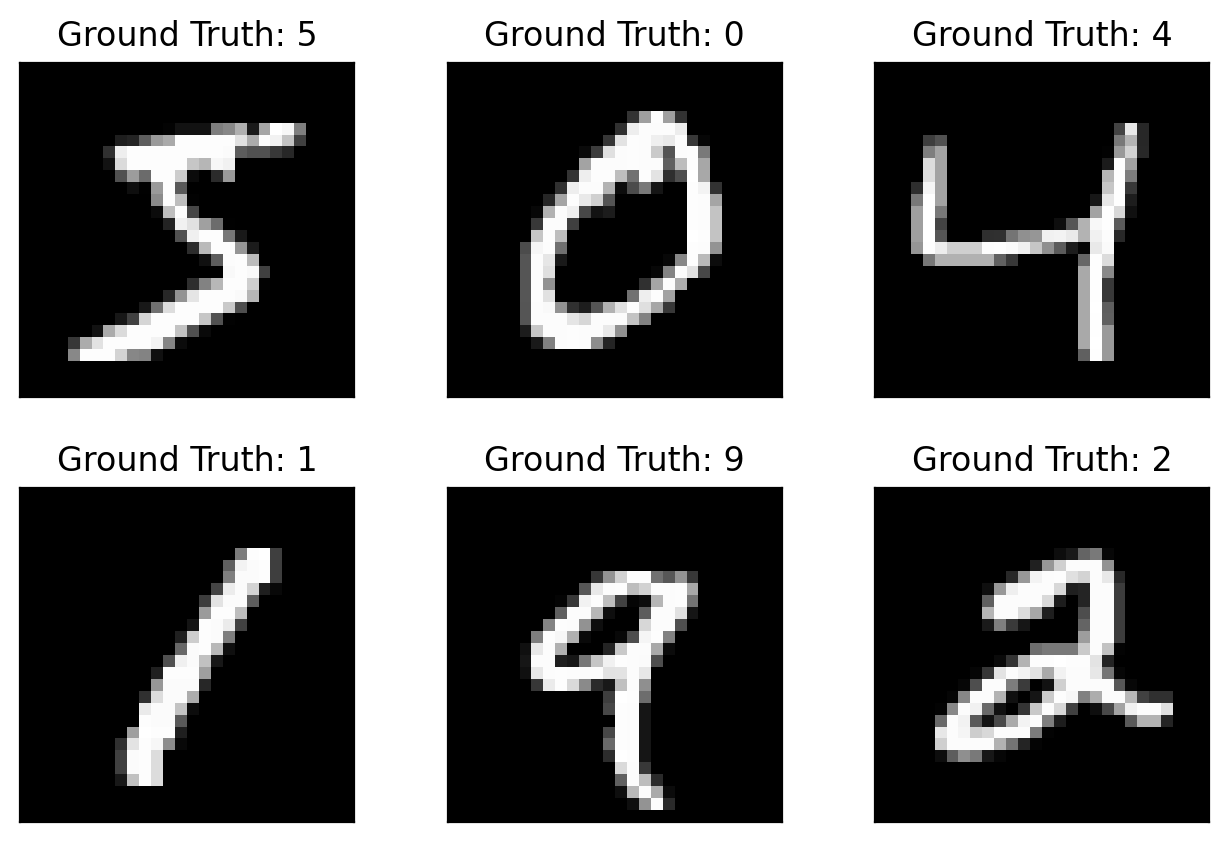

In [145]:
# Let's draw some of the training data
examples = enumerate(mnist_s)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [708]:
#plt.imshow(example_data[1][0], cmap='gray', interpolation='none')

In [671]:
#!pip install helpers

In [670]:
#from helpers import plot

In [10]:
orig_img = example_data[9]

NameError: name 'example_data' is not defined

In [11]:
# Transform MNIST data
from torchvision.transforms import v2
rotater = v2.RandomAffine(degrees=(-20, 20),scale=(0.8,1.2))
rotated_imgs = [rotater(orig_img) for _ in range(3)]


fig = plt.figure()
for i,imgy in enumerate(rotated_imgs):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(orig_img[0], cmap='gray', interpolation='none')
  #plt.imshow(example_data[i][0], cmap='Dark2', interpolation='none')
  plt.imshow(imgy[0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()    
#plot([orig_img] + rotated_imgs)


NameError: name 'orig_img' is not defined

# 1. Defining Model 

In [11]:
#torch.manual_seed(0) ###  for REPRODUCABILITY

def seed_all(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_all()

In [12]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512) ## previously 512 784-512
        #self.linear1a = nn.Linear(512, 512)
        
        self.linear2 = nn.Linear(512, latent_dims) #512 og
        self.linear3 = nn.Linear(512, latent_dims)
        
       # self.conv1 = nn.Conv2d(1, 2, kernel_size=3)
        
        #self.drop = nn.Dropout2d()
      #  self.fc1 = nn.Linear(338, 512)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):

        
        #x = self.conv1(x)
        #x = self.drop(x)
        #x = F.max_pool2d(x,2)
        #x = F.relu(x)
        #x = x.flatten(1)
        
        #x = self.fc1(x)
        
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        
        #x = F.relu(self.linear1a(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [148]:
#def train(autoencoder, nestdata, epochs=20): ## aug
#    opt = torch.optim.Adam(autoencoder.parameters())
#    for epoch in range(epochs):
#        for data in nestdata:
#            for x, y in data:
#                x = x.to(device) # GPU
#                opt.zero_grad()
#                x_hat = autoencoder(x)
#                loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
#                loss.backward()
#                opt.step()
#    return autoencoder

def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for idx,(x, y) in enumerate(data):
            if idx < 100000:
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
                loss.backward()
                opt.step()
    return autoencoder

In [16]:
#vae = VariationalAutoencoder(latent_dims).to(device) # GPU
#vae = train(vae, augmented_data4)

In [17]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = vae.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [710]:
#num_batches=100
#for i, (x, y) in enumerate(data):
#        z = vae.encoder(x.to(device))
#        z = z.to('cpu').detach().numpy()
#        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#        if i > num_batches:
#            plt.colorbar()
#            break

In [711]:
#z1 = [] 
#for i, (x, y) in enumerate(data):
#    z = vae.encoder(x.to(device))
#    k = vae.decoder(z)
#    z = z.to('cpu').detach().numpy()
#    z1.append(z)
#    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')

In [712]:
#plot_latent(vae, data)

In [17]:
def plot_reconstructed(autoencoder, r0=(-10, 20), r1=(-20, 10), n=20):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
           
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [18]:
#plot_reconstructed(vae)

In [19]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=30):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    print(z_1,z_2)
    #print(z)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    print(z)
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)

In [228]:
dataiter = iter(data)
#data2 = dataiter.next()

In [185]:
x, y = next(dataiter) # hack to grab a batch
x_1 = x[y == 7][1].to(device) # find a 1
x_2 = x[y == 7][2].to(device) # find a 0

In [186]:
#x_1

In [714]:
#interpolate_gif(vae, "vae", x_1, x_2)

# Classification Task 

28

In [50]:
##latent_dims=10
#vae = VariationalAutoencoder(latent_dims).to(device) # GPU
#vae = train(vae, mnist_s)


In [638]:
#for batch_idx, (data_a, target) in enumerate(data):
#    #print(batch_idx)
#    x_train = torch.tensor(vae.encoder(data_a.to(device)))
    
    

In [18]:
def get_latents(data):
    
    x_latents = []
    y_list=[]

    for x, y in data:

        x = x.to(device) # GPU

        z = vae.encoder(x)
        x_latents.append(z)
        y_list.append(y)

    x_latent_data = torch.cat(x_latents)
    y_train = torch.cat(y_list)
    x_train = torch.tensor(x_latent_data)
    return x_train, y_train

#x_train, y_train = get_latents(mnist_s)
#x_test, y_test = get_latents(test_mnist_s)
#x_aug_test , y_aug_test = get_latents(augmented_test_data)


In [720]:
#y_train[:50]

### One-Hot Encoding

In [19]:
#def oh_code(inp):
#    return torch.nn.functional.one_hot(torch.tensor(inp).long(), num_classes=10)
#
#y_train_oh = torch.nn.functional.one_hot(torch.tensor(y_train).long(), num_classes=10)

#y_test_oh = torch.nn.functional.one_hot(torch.tensor(y_test).long(), num_classes=10)
#y_aug_test_oh = torch.nn.functional.one_hot(torch.tensor(y_aug_test).long(), num_classes=10)


In [149]:
#x_test.shape

In [20]:
def CrossEntropyLoss_oh(pred, labels):
    return -torch.mean(torch.sum(labels*torch.log(pred), dim=1))

In [147]:


EPOCHS = 15000  # epochs
ALPHA = 0.005  # learning rate
BATCH = 100    # batch size

def log_reg_model(x_train,y_train_oh,x_test,y_test_oh,y_test,x_test2,y_test2,x_test3,y_test3,x_test4,y_test4):

    # m is the number of examples
    # n_x is the input size 28x28=784
    m, n_x = x_train.shape
    print(m,n_x)
    # model
    Z = torch.nn.Linear(n_x, 10, bias=True).to(device)
    torch.nn.init.zeros_(Z.weight)
    torch.nn.init.zeros_(Z.bias)
    A = torch.nn.Softmax(dim=1).to(device)

    # training graph and optimization
    optimizer = torch.optim.SGD(Z.parameters(), lr=ALPHA)
    #Z.parameters()
    #model.to(device)
    x_train = x_train.to(device)
    y_train_oh = y_train_oh.to(device)
    x_test = x_test.to(device)
    y_test_oh = y_test_oh.to(device)
    # Then move your optimizer to the same device as well
    #optimizer = torch.optim.SGD(Z.parameters(), lr=ALPHA).to(device)

    # loss and accuracy storage
    loss_plot = []; accA_plot = [];classacc_plot = []

    for epoch in range(EPOCHS + 1):
        # randomic batch definition
        # rbatch = np.random.choice(60000, size=BATCH)
        # variables initialization
        for chunk in range(0,60000,10000):

            X = torch.autograd.Variable(x_train[chunk:chunk+10000])
            Y = torch.autograd.Variable(y_train_oh[chunk:chunk+10000])
        #X = torch.autograd.Variable(x_train)
        #Y = torch.autograd.Variable(y_train_oh)
        #print(len(X),len(Y))
        #print(X)
        #print(Y)
        # training, metrics and storage
            optimizer.zero_grad()
            #print(A(Z(X)))
            L = CrossEntropyLoss_oh(A(Z(X)), Y)
            L.backward()
            optimizer.step()

        X_ = torch.autograd.Variable(x_test)
        Y_ = torch.autograd.Variable(y_test_oh)

        acc = torch.mean(1 - torch.abs(Y_ - A(Z(X_))))*100




        #acc = torch.mean(1 - torch.abs(Y - A(Z(X))))*100
        #print(acc)
        #loss_plot += [L]; accA_plot += [acc]
        if (not epoch % 1000) and (epoch != 0):
                counter=0
                counter_aug = 0 
                for item in torch.argmax(A(Z(x_test.to(device))),1)==y_test.to(device):
                    if item==torch.tensor(True):
                        counter += 1
                
                COUNTY2=0
    
                for item in torch.argmax(A(Z(x_test2.to(device))),1)==y_test2.to(device):
                                if item==torch.tensor(True):
                                    COUNTY2 += 1
                #print(COUNTY2, "here")
                
                COUNTY3 = 0 
                for item in torch.argmax(A(Z(x_test3.to(device))),1)==y_test3.to(device):
                                if item==torch.tensor(True):
                                    COUNTY3 += 1
                #print(COUNTY3, "now here")
                
                
                COUNTY4 = 0 
                for item in torch.argmax(A(Z(x_test4.to(device))),1)==y_test4.to(device):
                                if item==torch.tensor(True):
                                    COUNTY4 += 1
                #print(COUNTY4, "now herey")
                #for item in torch.argmax(A(Z(x_aug_test.to(device))),1)==y_aug_test.to(device):
                #    if item==torch.tensor(True):
                #        counter_aug += 1
                #for item in torch.argmax(A(Z(x_test.to(device))),1)==y_test.to(device):
                #    if item==torch.tensor(True):
                #        counter += 1

                acc2=counter/len(y_test) # s
                acc_fr=COUNTY2/len(y_test) # s
                acc_fs=COUNTY3/len(y_test) # s
                acc_rt=COUNTY4/len(y_test) # s
                
                acc_aug = counter_aug / len(y_test)
                classacc_plot += [counter]
                print('epoch: {0:04d} | loss: {1:.3f} | accuracy: {2:06.2f} % | accuracy2: {3: } | acc_aug: {4: } '.format(epoch, L, acc,acc2,acc_aug) )
    return acc2, acc_fr,acc_fs,acc_rt

#a1,a2 = log_reg_model(x_train,y_train_oh,x_test,y_test_oh,y_test)
#W_ = Z.cpu().weight.detach().numpy()
#B_ = Z.bias.detach().numpy()

In [139]:
#Evaluation Protocol
#x_train, y_train = get_latents(mnist_s)
#x_test, y_test = get_latents(test_mnist_s)


   

# 10 Latents MNIST-s

In [149]:

vae = VariationalAutoencoder(10).to(device) # GPU
vae = train(vae, mnist_s)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()

#x_test_fr, y_test_fr = get_latents(testingdata2)
#x_test_fs, y_test_fs = get_latents(testingdata3)
#x_test_rt, y_test_rt = get_latents(testingdata4)
#,
# LOG REG 
#acc1, acc2 = log_reg_model(x_train_s,y_train_s_oh,x_test_s,y_test_s_oh)
#print(acc1, acc2)


x_train_s, y_train_s = get_latents(mnist_s)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 10, ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    

/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/2310415253.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/2310415253.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/2310415253.py:11: UserWarning: To c

60000 10
epoch: 1000 | loss: 0.637 | accuracy: 091.67 % | accuracy2:  0.857 | acc_aug:  0.0 
epoch: 2000 | loss: 0.506 | accuracy: 093.40 % | accuracy2:  0.8667 | acc_aug:  0.0 
epoch: 3000 | loss: 0.458 | accuracy: 094.13 % | accuracy2:  0.8712 | acc_aug:  0.0 
epoch: 4000 | loss: 0.433 | accuracy: 094.54 % | accuracy2:  0.8737 | acc_aug:  0.0 
epoch: 5000 | loss: 0.418 | accuracy: 094.81 % | accuracy2:  0.8757 | acc_aug:  0.0 
epoch: 6000 | loss: 0.407 | accuracy: 095.01 % | accuracy2:  0.876 | acc_aug:  0.0 
epoch: 7000 | loss: 0.400 | accuracy: 095.16 % | accuracy2:  0.8777 | acc_aug:  0.0 
epoch: 8000 | loss: 0.394 | accuracy: 095.27 % | accuracy2:  0.8783 | acc_aug:  0.0 
epoch: 9000 | loss: 0.390 | accuracy: 095.37 % | accuracy2:  0.879 | acc_aug:  0.0 
epoch: 10000 | loss: 0.386 | accuracy: 095.44 % | accuracy2:  0.8794 | acc_aug:  0.0 
epoch: 11000 | loss: 0.383 | accuracy: 095.51 % | accuracy2:  0.8794 | acc_aug:  0.0 
epoch: 12000 | loss: 0.381 | accuracy: 095.57 % | accurac

# 20 latents mnist-s

In [150]:
#s:  0.7283  fr:  0.5842  fs:  0.6859  rt:  0.6536#  ##s:  0.8028  fr:  0.628  fs:  0.7088  rt:  0.7187
vae = VariationalAutoencoder(20).to(device) # GPU
vae = train(vae, mnist_s)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()



x_train_s, y_train_s = get_latents(mnist_s)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 20,twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    
    
    


/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/2057030140.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/2057030140.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/2057030140.py:12: UserWarning: To c

60000 20
epoch: 1000 | loss: 0.682 | accuracy: 091.42 % | accuracy2:  0.8282 | acc_aug:  0.0 
epoch: 2000 | loss: 0.559 | accuracy: 093.08 % | accuracy2:  0.8379 | acc_aug:  0.0 
epoch: 3000 | loss: 0.516 | accuracy: 093.75 % | accuracy2:  0.8436 | acc_aug:  0.0 
epoch: 4000 | loss: 0.494 | accuracy: 094.12 % | accuracy2:  0.8468 | acc_aug:  0.0 
epoch: 5000 | loss: 0.480 | accuracy: 094.36 % | accuracy2:  0.8488 | acc_aug:  0.0 
epoch: 6000 | loss: 0.471 | accuracy: 094.53 % | accuracy2:  0.8505 | acc_aug:  0.0 
epoch: 7000 | loss: 0.464 | accuracy: 094.66 % | accuracy2:  0.8515 | acc_aug:  0.0 
epoch: 8000 | loss: 0.459 | accuracy: 094.76 % | accuracy2:  0.8524 | acc_aug:  0.0 
epoch: 9000 | loss: 0.455 | accuracy: 094.84 % | accuracy2:  0.8539 | acc_aug:  0.0 
epoch: 10000 | loss: 0.452 | accuracy: 094.91 % | accuracy2:  0.8544 | acc_aug:  0.0 
epoch: 11000 | loss: 0.449 | accuracy: 094.97 % | accuracy2:  0.855 | acc_aug:  0.0 
epoch: 12000 | loss: 0.447 | accuracy: 095.01 % | accur

# 50 latents MNIST-S

In [151]:

vae = VariationalAutoencoder(50).to(device) # GPU
vae = train(vae, mnist_s)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()



x_train_s, y_train_s = get_latents(mnist_s)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 50,fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    
    



/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/2524278757.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/2524278757.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/2524278757.py:11: UserWarning: To c

60000 50
epoch: 1000 | loss: 0.663 | accuracy: 091.62 % | accuracy2:  0.8298 | acc_aug:  0.0 
epoch: 2000 | loss: 0.539 | accuracy: 093.28 % | accuracy2:  0.8397 | acc_aug:  0.0 
epoch: 3000 | loss: 0.495 | accuracy: 093.94 % | accuracy2:  0.8432 | acc_aug:  0.0 
epoch: 4000 | loss: 0.473 | accuracy: 094.31 % | accuracy2:  0.8465 | acc_aug:  0.0 
epoch: 5000 | loss: 0.460 | accuracy: 094.55 % | accuracy2:  0.8485 | acc_aug:  0.0 
epoch: 6000 | loss: 0.451 | accuracy: 094.72 % | accuracy2:  0.8495 | acc_aug:  0.0 
epoch: 7000 | loss: 0.444 | accuracy: 094.84 % | accuracy2:  0.8507 | acc_aug:  0.0 
epoch: 8000 | loss: 0.440 | accuracy: 094.94 % | accuracy2:  0.8523 | acc_aug:  0.0 
epoch: 9000 | loss: 0.436 | accuracy: 095.02 % | accuracy2:  0.8528 | acc_aug:  0.0 
epoch: 10000 | loss: 0.433 | accuracy: 095.08 % | accuracy2:  0.8529 | acc_aug:  0.0 
epoch: 11000 | loss: 0.430 | accuracy: 095.14 % | accuracy2:  0.853 | acc_aug:  0.0 
epoch: 12000 | loss: 0.428 | accuracy: 095.18 % | accur

In [152]:

vae = VariationalAutoencoder(100).to(device) # GPU
vae = train(vae, mnist_s)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()



x_train_s, y_train_s = get_latents(mnist_s)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 100,hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    
    



/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/1875109772.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/1875109772.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/1875109772.py:11: UserWarning: To c

60000 100
epoch: 1000 | loss: 0.674 | accuracy: 091.45 % | accuracy2:  0.8235 | acc_aug:  0.0 
epoch: 2000 | loss: 0.545 | accuracy: 093.13 % | accuracy2:  0.8361 | acc_aug:  0.0 
epoch: 3000 | loss: 0.499 | accuracy: 093.81 % | accuracy2:  0.8407 | acc_aug:  0.0 
epoch: 4000 | loss: 0.475 | accuracy: 094.20 % | accuracy2:  0.8445 | acc_aug:  0.0 
epoch: 5000 | loss: 0.460 | accuracy: 094.45 % | accuracy2:  0.848 | acc_aug:  0.0 
epoch: 6000 | loss: 0.450 | accuracy: 094.62 % | accuracy2:  0.8502 | acc_aug:  0.0 
epoch: 7000 | loss: 0.443 | accuracy: 094.76 % | accuracy2:  0.8509 | acc_aug:  0.0 
epoch: 8000 | loss: 0.438 | accuracy: 094.86 % | accuracy2:  0.8517 | acc_aug:  0.0 
epoch: 9000 | loss: 0.433 | accuracy: 094.94 % | accuracy2:  0.853 | acc_aug:  0.0 
epoch: 10000 | loss: 0.430 | accuracy: 095.01 % | accuracy2:  0.8539 | acc_aug:  0.0 
epoch: 11000 | loss: 0.427 | accuracy: 095.07 % | accuracy2:  0.8542 | acc_aug:  0.0 
epoch: 12000 | loss: 0.425 | accuracy: 095.12 % | accur

# --------------------------------------------------------------------------
# MNIST - S EVALS
# --------------------------------------------------------------------------

In [153]:

latents,acc2,acc_fr,acc_fs, acc_rt = 10, ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)

latents,acc2,acc_fr,acc_fs, acc_rt = 20, twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 50, fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 100, hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt 

print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents:  10  s:  0.8799  fr:  0.6846  fs:  0.8228  rt:  0.8067
latents:  20  s:  0.8564  fr:  0.6721  fs:  0.7624  rt:  0.7713
latents:  50  s:  0.8547  fr:  0.6739  fs:  0.7737  rt:  0.7837
latents:  100  s:  0.855  fr:  0.6826  fs:  0.7778  rt:  0.7742


# ------------------------------------------------------------------
# MNIST - RT 
# ------------------------------------------------------------------


# 5 latents - MNIST RT

In [154]:

vae = VariationalAutoencoder(5).to(device) # GPU
vae = train(vae, mnist_rt)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()

#x_test_fr, y_test_fr = get_latents(testingdata2)
#x_test_fs, y_test_fs = get_latents(testingdata3)
#x_test_rt, y_test_rt = get_latents(testingdata4)
#,
# LOG REG 
#acc1, acc2 = log_reg_model(x_train_s,y_train_s_oh,x_test_s,y_test_s_oh)
#print(acc1, acc2)


x_train_s, y_train_s = get_latents(mnist_rt)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



fiv_acc2, fiv_acc_fr,fiv_acc_fs,fiv_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 5, fiv_acc2, fiv_acc_fr,fiv_acc_fs,fiv_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    

/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/3627895446.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/3627895446.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/3627895446.py:11: UserWarning: To c

60000 5
epoch: 1000 | loss: 0.987 | accuracy: 089.58 % | accuracy2:  0.7916 | acc_aug:  0.0 
epoch: 2000 | loss: 0.845 | accuracy: 091.21 % | accuracy2:  0.8058 | acc_aug:  0.0 
epoch: 3000 | loss: 0.790 | accuracy: 091.95 % | accuracy2:  0.8114 | acc_aug:  0.0 
epoch: 4000 | loss: 0.762 | accuracy: 092.37 % | accuracy2:  0.8129 | acc_aug:  0.0 
epoch: 5000 | loss: 0.744 | accuracy: 092.66 % | accuracy2:  0.8134 | acc_aug:  0.0 
epoch: 6000 | loss: 0.733 | accuracy: 092.86 % | accuracy2:  0.814 | acc_aug:  0.0 
epoch: 7000 | loss: 0.724 | accuracy: 093.01 % | accuracy2:  0.8146 | acc_aug:  0.0 
epoch: 8000 | loss: 0.718 | accuracy: 093.13 % | accuracy2:  0.8158 | acc_aug:  0.0 
epoch: 9000 | loss: 0.714 | accuracy: 093.22 % | accuracy2:  0.8158 | acc_aug:  0.0 
epoch: 10000 | loss: 0.710 | accuracy: 093.30 % | accuracy2:  0.8163 | acc_aug:  0.0 
epoch: 11000 | loss: 0.707 | accuracy: 093.37 % | accuracy2:  0.8167 | acc_aug:  0.0 
epoch: 12000 | loss: 0.705 | accuracy: 093.42 % | accura

# 10 LATESNTS - MINST RT

In [155]:
## expecting 0.8102 ## 8039 ... AFTER RANDOM SEED SET : 0.8118 now it's 0.7941 // redoing again: 42 new seed alloc : 7992,6585 now 8054///
## restarting kernal.... 0.8118  ## then 7941 again
vae = VariationalAutoencoder(10).to(device) # GPU
vae = train(vae, mnist_rt)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()

#x_test_fr, y_test_fr = get_latents(testingdata2)
#x_test_fs, y_test_fs = get_latents(testingdata3)
#x_test_rt, y_test_rt = get_latents(testingdata4)
#,
# LOG REG 
#acc1, acc2 = log_reg_model(x_train_s,y_train_s_oh,x_test_s,y_test_s_oh)
#print(acc1, acc2)


x_train_s, y_train_s = get_latents(mnist_rt)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 10, ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    

/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/3489330482.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/3489330482.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/3489330482.py:13: UserWarning: To 

60000 10
epoch: 1000 | loss: 0.859 | accuracy: 090.91 % | accuracy2:  0.8412 | acc_aug:  0.0 
epoch: 2000 | loss: 0.719 | accuracy: 092.68 % | accuracy2:  0.851 | acc_aug:  0.0 
epoch: 3000 | loss: 0.668 | accuracy: 093.41 % | accuracy2:  0.8542 | acc_aug:  0.0 
epoch: 4000 | loss: 0.641 | accuracy: 093.83 % | accuracy2:  0.8566 | acc_aug:  0.0 
epoch: 5000 | loss: 0.625 | accuracy: 094.10 % | accuracy2:  0.8596 | acc_aug:  0.0 
epoch: 6000 | loss: 0.614 | accuracy: 094.30 % | accuracy2:  0.8605 | acc_aug:  0.0 
epoch: 7000 | loss: 0.607 | accuracy: 094.44 % | accuracy2:  0.8613 | acc_aug:  0.0 
epoch: 8000 | loss: 0.601 | accuracy: 094.55 % | accuracy2:  0.8624 | acc_aug:  0.0 
epoch: 9000 | loss: 0.597 | accuracy: 094.64 % | accuracy2:  0.8629 | acc_aug:  0.0 
epoch: 10000 | loss: 0.594 | accuracy: 094.71 % | accuracy2:  0.863 | acc_aug:  0.0 
epoch: 11000 | loss: 0.591 | accuracy: 094.78 % | accuracy2:  0.8629 | acc_aug:  0.0 
epoch: 12000 | loss: 0.589 | accuracy: 094.83 % | accura

# 20 latents mnist-rt

In [156]:

vae = VariationalAutoencoder(20).to(device) # GPU
vae = train(vae, mnist_rt)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()



x_train_s, y_train_s = get_latents(mnist_rt)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 20,twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    
    
    


/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/3112856649.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/3112856649.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/3112856649.py:11: UserWarning: To c

60000 20
epoch: 1000 | loss: 0.844 | accuracy: 091.39 % | accuracy2:  0.8324 | acc_aug:  0.0 
epoch: 2000 | loss: 0.725 | accuracy: 092.98 % | accuracy2:  0.8399 | acc_aug:  0.0 
epoch: 3000 | loss: 0.684 | accuracy: 093.61 % | accuracy2:  0.8443 | acc_aug:  0.0 
epoch: 4000 | loss: 0.664 | accuracy: 093.95 % | accuracy2:  0.8457 | acc_aug:  0.0 
epoch: 5000 | loss: 0.651 | accuracy: 094.16 % | accuracy2:  0.8464 | acc_aug:  0.0 
epoch: 6000 | loss: 0.643 | accuracy: 094.31 % | accuracy2:  0.8476 | acc_aug:  0.0 
epoch: 7000 | loss: 0.638 | accuracy: 094.42 % | accuracy2:  0.8482 | acc_aug:  0.0 
epoch: 8000 | loss: 0.634 | accuracy: 094.50 % | accuracy2:  0.849 | acc_aug:  0.0 
epoch: 9000 | loss: 0.630 | accuracy: 094.57 % | accuracy2:  0.8494 | acc_aug:  0.0 
epoch: 10000 | loss: 0.628 | accuracy: 094.62 % | accuracy2:  0.8496 | acc_aug:  0.0 
epoch: 11000 | loss: 0.626 | accuracy: 094.66 % | accuracy2:  0.8497 | acc_aug:  0.0 
epoch: 12000 | loss: 0.624 | accuracy: 094.70 % | accur

# 50 latents MNIST-rt

In [157]:

vae = VariationalAutoencoder(50).to(device) # GPU
vae = train(vae, mnist_rt)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()



x_train_s, y_train_s = get_latents(mnist_rt)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 50,fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    
    



/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/2758850253.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/2758850253.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/2758850253.py:11: UserWarning: To c

60000 50
epoch: 1000 | loss: 0.855 | accuracy: 091.28 % | accuracy2:  0.8349 | acc_aug:  0.0 
epoch: 2000 | loss: 0.723 | accuracy: 092.99 % | accuracy2:  0.843 | acc_aug:  0.0 
epoch: 3000 | loss: 0.675 | accuracy: 093.66 % | accuracy2:  0.8462 | acc_aug:  0.0 
epoch: 4000 | loss: 0.650 | accuracy: 094.03 % | accuracy2:  0.8486 | acc_aug:  0.0 
epoch: 5000 | loss: 0.635 | accuracy: 094.26 % | accuracy2:  0.8494 | acc_aug:  0.0 
epoch: 6000 | loss: 0.625 | accuracy: 094.43 % | accuracy2:  0.851 | acc_aug:  0.0 
epoch: 7000 | loss: 0.617 | accuracy: 094.55 % | accuracy2:  0.8519 | acc_aug:  0.0 
epoch: 8000 | loss: 0.612 | accuracy: 094.65 % | accuracy2:  0.8524 | acc_aug:  0.0 
epoch: 9000 | loss: 0.607 | accuracy: 094.72 % | accuracy2:  0.8526 | acc_aug:  0.0 
epoch: 10000 | loss: 0.604 | accuracy: 094.78 % | accuracy2:  0.8535 | acc_aug:  0.0 
epoch: 11000 | loss: 0.601 | accuracy: 094.84 % | accuracy2:  0.8541 | acc_aug:  0.0 
epoch: 12000 | loss: 0.599 | accuracy: 094.88 % | accura

# 100 latents mnist -rt

In [158]:

vae = VariationalAutoencoder(100).to(device) # GPU
vae = train(vae, mnist_rt)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()



x_train_s, y_train_s = get_latents(mnist_rt)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)



hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 100,hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    
    



/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/1488157914.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/1488157914.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/1488157914.py:11: UserWarning: To c

60000 100
epoch: 1000 | loss: 0.841 | accuracy: 091.42 % | accuracy2:  0.8379 | acc_aug:  0.0 
epoch: 2000 | loss: 0.711 | accuracy: 093.07 % | accuracy2:  0.8472 | acc_aug:  0.0 
epoch: 3000 | loss: 0.663 | accuracy: 093.73 % | accuracy2:  0.8513 | acc_aug:  0.0 
epoch: 4000 | loss: 0.639 | accuracy: 094.09 % | accuracy2:  0.853 | acc_aug:  0.0 
epoch: 5000 | loss: 0.623 | accuracy: 094.32 % | accuracy2:  0.8529 | acc_aug:  0.0 
epoch: 6000 | loss: 0.613 | accuracy: 094.48 % | accuracy2:  0.853 | acc_aug:  0.0 
epoch: 7000 | loss: 0.606 | accuracy: 094.60 % | accuracy2:  0.8543 | acc_aug:  0.0 
epoch: 8000 | loss: 0.600 | accuracy: 094.70 % | accuracy2:  0.854 | acc_aug:  0.0 
epoch: 9000 | loss: 0.596 | accuracy: 094.77 % | accuracy2:  0.8542 | acc_aug:  0.0 
epoch: 10000 | loss: 0.592 | accuracy: 094.83 % | accuracy2:  0.855 | acc_aug:  0.0 
epoch: 11000 | loss: 0.590 | accuracy: 094.88 % | accuracy2:  0.8549 | acc_aug:  0.0 
epoch: 12000 | loss: 0.587 | accuracy: 094.93 % | accurac

# --------------------------------------------------------------------------
# MNIST - rt EVALS
# --------------------------------------------------------------------------

In [159]:

latents,acc2,acc_fr,acc_fs, acc_rt = 10, ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)

latents,acc2,acc_fr,acc_fs, acc_rt = 20, twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 50, fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 100, hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt 

print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents:  10  s:  0.8632  fr:  0.7386  fs:  0.8238  rt:  0.807
latents:  20  s:  0.8504  fr:  0.7289  fs:  0.7734  rt:  0.7951
latents:  50  s:  0.8561  fr:  0.7334  fs:  0.7906  rt:  0.8089
latents:  100  s:  0.8563  fr:  0.7378  fs:  0.7965  rt:  0.7983


# --------------------------------------------------------------------------
# Reducing training set..
# --------------------------------------------------------------------------

In [ ]:
## manually changing data passed to logistic regression

In [196]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for idx,(x, y) in enumerate(data):
            if idx < 2: # 128 in each batch so 2
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
                loss.backward()
                opt.step()
    return autoencoder

In [241]:

vae = VariationalAutoencoder(10).to(device) # GPU
vae = train(vae, mnist_s)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()

#x_test_fr, y_test_fr = get_latents(testingdata2)
#x_test_fs, y_test_fs = get_latents(testingdata3)
#x_test_rt, y_test_rt = get_latents(testingdata4)
#,
# LOG REG 
#acc1, acc2 = log_reg_model(x_train_s,y_train_s_oh,x_test_s,y_test_s_oh)
#print(acc1, acc2)


x_train_s, y_train_s = get_latents(mnist_s)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)


num = 128*2
ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt  = log_reg_model(x_train_s[:num],y_train_s_oh[:num]
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 10, ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    

/tmp/ipykernel_11114/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_11114/437372431.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_11114/437372431.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_11114/437372431.py:11: UserWarning: To copy

256 10
epoch: 1000 | loss: nan | accuracy: 086.92 % | accuracy2:  0.554 | acc_aug:  0.0 
epoch: 2000 | loss: nan | accuracy: 087.96 % | accuracy2:  0.5704 | acc_aug:  0.0 
epoch: 3000 | loss: nan | accuracy: 088.43 % | accuracy2:  0.5744 | acc_aug:  0.0 
epoch: 4000 | loss: nan | accuracy: 088.71 % | accuracy2:  0.5747 | acc_aug:  0.0 
epoch: 5000 | loss: nan | accuracy: 088.90 % | accuracy2:  0.5724 | acc_aug:  0.0 
epoch: 6000 | loss: nan | accuracy: 089.02 % | accuracy2:  0.5729 | acc_aug:  0.0 
epoch: 7000 | loss: nan | accuracy: 089.12 % | accuracy2:  0.5721 | acc_aug:  0.0 
epoch: 8000 | loss: nan | accuracy: 089.19 % | accuracy2:  0.5724 | acc_aug:  0.0 
epoch: 9000 | loss: nan | accuracy: 089.25 % | accuracy2:  0.5703 | acc_aug:  0.0 
epoch: 10000 | loss: nan | accuracy: 089.29 % | accuracy2:  0.5704 | acc_aug:  0.0 
epoch: 11000 | loss: nan | accuracy: 089.33 % | accuracy2:  0.5696 | acc_aug:  0.0 
epoch: 12000 | loss: nan | accuracy: 089.36 % | accuracy2:  0.5674 | acc_aug:  

In [200]:
#latents:  10  s:  0.5621  fr:  0.4612  fs:  0.4997  rt:  0.5053

#x_train_s[:10]

In [199]:
#for idx,(x, y) in enumerate(mnist_s):
#            if idx < 10:
#                print(len(x))



In [ ]:
#PCA


In [230]:
from sklearn.decomposition import PCA
import pandas as pd
x_train_sNP = x_train_s.cpu().numpy()
y_train_snp=y_train_s.numpy()
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_train_sNP)


In [231]:
label_color_dict = {0:'x',1:'o',2:'x',3:'0',4:'0',5:'0',6:'0',7:'0',8:'0',9:'0'}

# Color vector creation
cvec = [label_color_dict[label] for label in y_train_snp]

In [232]:
pc1 = [x1 for x1,x2 in principalComponents]
pc2 = [x2 for x1,x2 in principalComponents]


In [238]:
import seaborn as sns
sns.scatterplot(x=pc1[:200], y=pc2[:200], style=y_train_snp[:200],palette="deep")

NameError: name 'matplotlib' is not defined

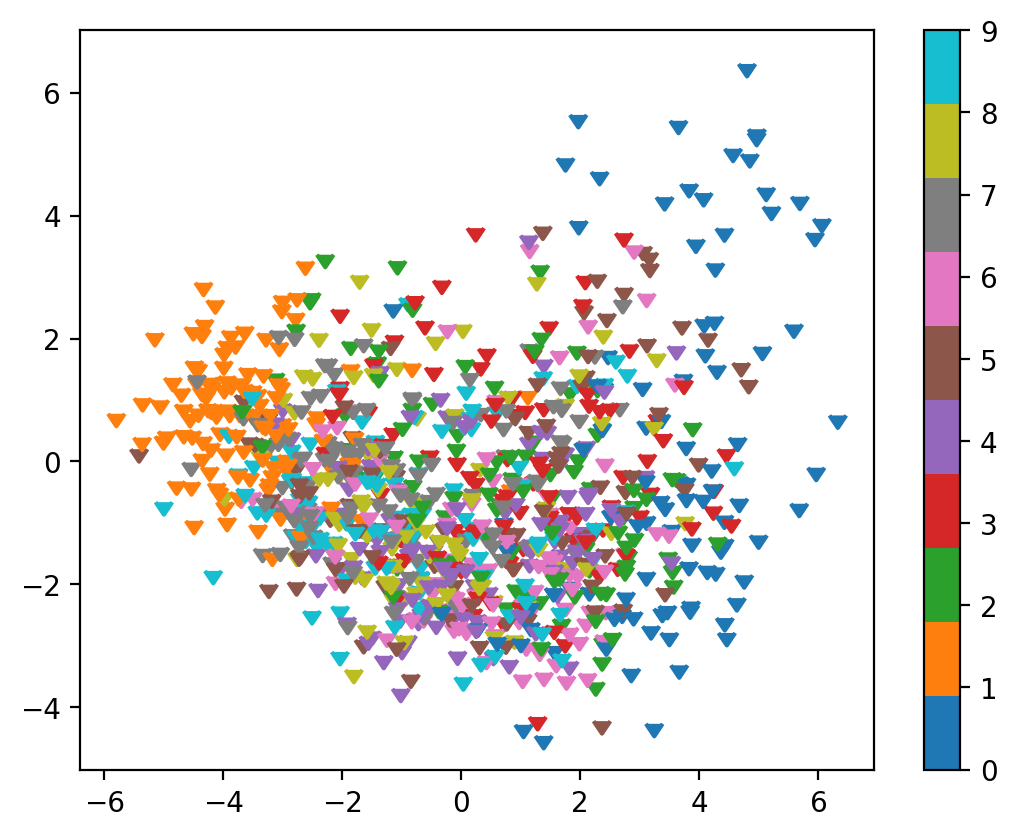

In [240]:

import matplotlib
plt.scatter(pc1[:1000],pc2[:1000],c=y_train_snp[:1000],cmap='tab10',marker=matplotlib.markers.CARETDOWNBASE)
plt.colorbar()

In [175]:
### TESTING SKLEARN




x_train_sNP = x_train_s.cpu().numpy()
y_train_s_ohNP = y_train_s_oh.numpy()
y_train_snp=y_train_s.numpy()

In [166]:
x_test_snp = x_test_s.cpu().numpy()

In [167]:
y_test_snp = y_test_s.cpu().numpy()

In [176]:

from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(x_train_sNP[:1000], y_train_snp[:1000])

LogisticRegression(random_state=16)

In [177]:
y_pred = logreg.predict(x_test_snp)

In [178]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test_snp, y_pred)
cnf_matrix



array([[ 912,    0,   15,    7,    4,    7,   17,    5,    6,    7],
       [   0, 1047,   22,    4,    2,    9,    7,   18,   19,    7],
       [  17,   27,  871,    9,   13,    2,   13,   35,   41,    4],
       [  19,    6,   48,  818,    1,   62,    5,    9,   36,    6],
       [   0,    6,   15,    4,  811,    2,   18,    7,    2,  117],
       [  23,   20,    5,   38,    9,  687,   30,    2,   67,   11],
       [   8,   25,   39,    2,   14,   34,  830,    1,    5,    0],
       [   2,   18,   33,    2,    7,    6,    0,  892,    4,   64],
       [  10,    4,   69,   24,    5,   17,    6,    8,  789,   42],
       [   6,    6,   28,    9,   55,    6,    2,   63,    7,  827]])

In [179]:
count=0
for a,b in zip(y_test_snp, y_pred):
    if a ==b:
        #print(a,b)
        count+=1
print(count/len(y_test_snp))

0.8484


In [180]:

x_test_rtnp = x_test_rt.cpu().numpy()
y_test_rtnp =  y_test_rt.numpy()


y_pred2 = logreg.predict(x_test_rtnp)


cnf_matrix = metrics.confusion_matrix(y_test_rtnp, y_pred2)
cnf_matrix



array([[864,   1,  30,  12,   7,  18,  18,   8,   7,  15],
       [  0, 960,  63,   7,   2,  57,   4,  10,  30,   2],
       [ 21,  28, 800,  26,  30,   7,  22,  37,  52,   9],
       [ 19,   3,  69, 748,   2, 102,   8,   8,  43,   8],
       [  2,  10,  54,   5, 722,   6,  22,  17,   8, 136],
       [ 30,  22,   8,  36,  24, 627,  54,   5,  76,  10],
       [  7,  21,  60,   4,  20,  63, 768,   5,   8,   2],
       [  9,  12,  58,   9,  29,   6,   0, 786,   4, 115],
       [ 13,  13, 118,  25,  12,  21,  13,  10, 696,  53],
       [  6,   9,  57,   3,  71,  11,   5, 116,   9, 722]])

In [181]:
count=0
for a,b in zip(y_test_rtnp, y_pred2):
    if a ==b:
        #print(a,b)
        count+=1
print(count/len(y_test_snp))

0.7693


In [174]:
#7343 originally...

In [31]:

vae = VariationalAutoencoder(50).to(device) # GPU
vae = train(vae, mnist_rt)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()

#x_test_fr, y_test_fr = get_latents(testingdata2)
#x_test_fs, y_test_fs = get_latents(testingdata3)
#x_test_rt, y_test_rt = get_latents(testingdata4)
#,
# LOG REG 
#acc1, acc2 = log_reg_model(x_train_s,y_train_s_oh,x_test_s,y_test_s_oh)
#print(acc1, acc2)


x_train_s, y_train_s = get_latents(mnist_rt)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)


x_train_rt, y_train_rt = get_latents(mnist_rt)
y_train_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_train_rt).long(), num_classes=10)


fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt  = log_reg_model(x_train_rt,y_train_rt_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 50, fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt    
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    

/tmp/ipykernel_7549/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_7549/3769501855.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_7549/3769501855.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_7549/3769501855.py:11: UserWarning: To copy 

60000 50
epoch: 1000 | loss: 1.095 | accuracy: 089.34 % | accuracy2:  0.7877 | acc_aug:  0.0 
epoch: 2000 | loss: 0.953 | accuracy: 091.19 % | accuracy2:  0.791 | acc_aug:  0.0 
epoch: 3000 | loss: 0.905 | accuracy: 091.93 % | accuracy2:  0.7921 | acc_aug:  0.0 
epoch: 4000 | loss: 0.880 | accuracy: 092.34 % | accuracy2:  0.7939 | acc_aug:  0.0 
epoch: 5000 | loss: 0.866 | accuracy: 092.59 % | accuracy2:  0.7949 | acc_aug:  0.0 
epoch: 6000 | loss: 0.857 | accuracy: 092.76 % | accuracy2:  0.7954 | acc_aug:  0.0 
epoch: 7000 | loss: 0.851 | accuracy: 092.88 % | accuracy2:  0.7957 | acc_aug:  0.0 
epoch: 8000 | loss: 0.847 | accuracy: 092.98 % | accuracy2:  0.7958 | acc_aug:  0.0 
epoch: 9000 | loss: 0.843 | accuracy: 093.05 % | accuracy2:  0.7971 | acc_aug:  0.0 
epoch: 10000 | loss: 0.841 | accuracy: 093.11 % | accuracy2:  0.7978 | acc_aug:  0.0 
epoch: 11000 | loss: 0.839 | accuracy: 093.16 % | accuracy2:  0.7981 | acc_aug:  0.0 
epoch: 12000 | loss: 0.837 | accuracy: 093.20 % | accur

In [30]:

vae = VariationalAutoencoder(100).to(device) # GPU
vae = train(vae, mnist_rt)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()

#x_test_fr, y_test_fr = get_latents(testingdata2)
#x_test_fs, y_test_fs = get_latents(testingdata3)
#x_test_rt, y_test_rt = get_latents(testingdata4)
#,
# LOG REG 
#acc1, acc2 = log_reg_model(x_train_s,y_train_s_oh,x_test_s,y_test_s_oh)
#print(acc1, acc2)


x_train_s, y_train_s = get_latents(mnist_s)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)


x_train_rt, y_train_rt = get_latents(mnist_rt)
y_train_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_train_rt).long(), num_classes=10)




hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt   = log_reg_model(x_train_rt,y_train_rt_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 100, hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt 
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    

/tmp/ipykernel_7549/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_7549/137651380.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_7549/137651380.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_7549/137651380.py:11: UserWarning: To copy con

60000 100
epoch: 1000 | loss: 1.082 | accuracy: 089.38 % | accuracy2:  0.7806 | acc_aug:  0.0 
epoch: 2000 | loss: 0.939 | accuracy: 091.20 % | accuracy2:  0.7877 | acc_aug:  0.0 
epoch: 3000 | loss: 0.890 | accuracy: 091.94 % | accuracy2:  0.7914 | acc_aug:  0.0 
epoch: 4000 | loss: 0.865 | accuracy: 092.34 % | accuracy2:  0.7932 | acc_aug:  0.0 
epoch: 5000 | loss: 0.851 | accuracy: 092.59 % | accuracy2:  0.7933 | acc_aug:  0.0 
epoch: 6000 | loss: 0.842 | accuracy: 092.76 % | accuracy2:  0.7939 | acc_aug:  0.0 
epoch: 7000 | loss: 0.835 | accuracy: 092.89 % | accuracy2:  0.7947 | acc_aug:  0.0 
epoch: 8000 | loss: 0.830 | accuracy: 092.98 % | accuracy2:  0.7955 | acc_aug:  0.0 
epoch: 9000 | loss: 0.827 | accuracy: 093.06 % | accuracy2:  0.7964 | acc_aug:  0.0 
epoch: 10000 | loss: 0.824 | accuracy: 093.12 % | accuracy2:  0.7973 | acc_aug:  0.0 
epoch: 11000 | loss: 0.822 | accuracy: 093.17 % | accuracy2:  0.7972 | acc_aug:  0.0 
epoch: 12000 | loss: 0.820 | accuracy: 093.21 % | acc

In [28]:

vae = VariationalAutoencoder(50).to(device) # GPU
vae = train(vae, mnist_rt2)

x_test_s, y_test_s = get_latents(test_mnist_s)
y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)

x_test_fr, y_test_fr = get_latents(test_mnist_fr)
y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()

x_test_fs, y_test_fs = get_latents(test_mnist_fs)
y_test_fs_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fs).long(), num_classes=10).clone().detach()

x_test_rt, y_test_rt = get_latents(test_mnist_rt)
y_test_rt_oh = torch.nn.functional.one_hot(torch.tensor(y_test_rt).long(), num_classes=10).clone().detach()

#x_test_fr, y_test_fr = get_latents(testingdata2)
#x_test_fs, y_test_fs = get_latents(testingdata3)
#x_test_rt, y_test_rt = get_latents(testingdata4)
#,
# LOG REG 
#acc1, acc2 = log_reg_model(x_train_s,y_train_s_oh,x_test_s,y_test_s_oh)
#print(acc1, acc2)


x_train_s, y_train_s = get_latents(mnist_rt2)
y_train_s_oh = torch.nn.functional.one_hot(torch.tensor(y_train_s).long(), num_classes=10)


fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt  = log_reg_model(x_train_s,y_train_s_oh
                           ,x_test_s,y_test_s_oh,y_test_s
                           ,x_test_fr,y_test_fr
                          ,x_test_fs,y_test_fs
                          ,x_test_rt,y_test_rt)   

latents,acc2,acc_fr,acc_fs, acc_rt = 50, fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt    
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)
    

/tmp/ipykernel_7549/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_7549/3439943303.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_7549/3439943303.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_7549/3439943303.py:11: UserWarning: To copy 

60000 50
epoch: 1000 | loss: 0.969 | accuracy: 089.34 % | accuracy2:  0.7781 | acc_aug:  0.0 
epoch: 2000 | loss: 0.813 | accuracy: 091.20 % | accuracy2:  0.785 | acc_aug:  0.0 
epoch: 3000 | loss: 0.758 | accuracy: 091.97 % | accuracy2:  0.7868 | acc_aug:  0.0 
epoch: 4000 | loss: 0.729 | accuracy: 092.40 % | accuracy2:  0.7891 | acc_aug:  0.0 
epoch: 5000 | loss: 0.712 | accuracy: 092.67 % | accuracy2:  0.79 | acc_aug:  0.0 
epoch: 6000 | loss: 0.700 | accuracy: 092.86 % | accuracy2:  0.7915 | acc_aug:  0.0 
epoch: 7000 | loss: 0.692 | accuracy: 093.00 % | accuracy2:  0.7922 | acc_aug:  0.0 
epoch: 8000 | loss: 0.686 | accuracy: 093.11 % | accuracy2:  0.7928 | acc_aug:  0.0 
epoch: 9000 | loss: 0.681 | accuracy: 093.20 % | accuracy2:  0.7938 | acc_aug:  0.0 
epoch: 10000 | loss: 0.677 | accuracy: 093.27 % | accuracy2:  0.7944 | acc_aug:  0.0 
epoch: 11000 | loss: 0.674 | accuracy: 093.33 % | accuracy2:  0.7952 | acc_aug:  0.0 
epoch: 12000 | loss: 0.672 | accuracy: 093.38 % | accurac

In [ ]:
## MAY be worth switching to sklearn


In [20]:

latents,acc2,acc_fr,acc_fs, acc_rt = 10, ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)

latents,acc2,acc_fr,acc_fs, acc_rt = 20, twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 50, fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 100, hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt 

print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents:  10  s:  0.7924  fr:  0.7274  fs:  0.7521  rt:  0.7512
latents:  20  s:  0.7928  fr:  0.7489  fs:  0.7449  rt:  0.7512
latents:  50  s:  0.7914  fr:  0.7323  fs:  0.7506  rt:  0.7517
latents:  100  s:  0.7922  fr:  0.7428  fs:  0.7513  rt:  0.7544


In [21]:

vae = VariationalAutoencoder(10).to(device) # GPU
vae = train(vae, mnist_rt2)
ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt = scenario_runs(10,mnist_rt2,test_mnist_s,test_mnist_fr,test_mnist_fs,test_mnist_rt)

vae = VariationalAutoencoder(20).to(device) # GPU
vae = train(vae, mnist_rt2)
twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt = scenario_runs(20,mnist_rt2,test_mnist_s,test_mnist_fr,test_mnist_fs,test_mnist_rt)

vae = VariationalAutoencoder(50).to(device) # GPU
vae = train(vae, mnist_rt2)
fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt = scenario_runs(50,mnist_rt2,test_mnist_s,test_mnist_fr,test_mnist_fs,test_mnist_rt)


vae = VariationalAutoencoder(100).to(device) # GPU
vae = train(vae, mnist_rt2)
hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt = scenario_runs(100,mnist_rt2,test_mnist_s,test_mnist_fr,test_mnist_fs,test_mnist_rt)

/tmp/ipykernel_7549/2988415686.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)
/tmp/ipykernel_7549/2738957415.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_s_oh = torch.nn.functional.one_hot(torch.tensor(y_test_s).long(), num_classes=10)
/tmp/ipykernel_7549/2738957415.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_fr_oh = torch.nn.functional.one_hot(torch.tensor(y_test_fr).long(), num_classes=10).clone().detach()
/tmp/ipykernel_7549/2738957415.py:13: UserWarning: To copy

60000 10
epoch: 1000 | loss: 0.989 | accuracy: 089.16 % | accuracy2:  0.7782 | acc_aug:  0.0 
epoch: 2000 | loss: 0.827 | accuracy: 091.03 % | accuracy2:  0.7851 | acc_aug:  0.0 
epoch: 3000 | loss: 0.767 | accuracy: 091.83 % | accuracy2:  0.7894 | acc_aug:  0.0 
epoch: 4000 | loss: 0.737 | accuracy: 092.28 % | accuracy2:  0.7911 | acc_aug:  0.0 
epoch: 5000 | loss: 0.718 | accuracy: 092.57 % | accuracy2:  0.7929 | acc_aug:  0.0 
epoch: 6000 | loss: 0.706 | accuracy: 092.78 % | accuracy2:  0.7946 | acc_aug:  0.0 
epoch: 7000 | loss: 0.697 | accuracy: 092.93 % | accuracy2:  0.7956 | acc_aug:  0.0 
epoch: 8000 | loss: 0.690 | accuracy: 093.05 % | accuracy2:  0.7965 | acc_aug:  0.0 
epoch: 9000 | loss: 0.685 | accuracy: 093.15 % | accuracy2:  0.7964 | acc_aug:  0.0 
epoch: 10000 | loss: 0.681 | accuracy: 093.22 % | accuracy2:  0.7959 | acc_aug:  0.0 
epoch: 11000 | loss: 0.678 | accuracy: 093.29 % | accuracy2:  0.7962 | acc_aug:  0.0 
epoch: 12000 | loss: 0.676 | accuracy: 093.34 % | accu

In [22]:

latents,acc2,acc_fr,acc_fs, acc_rt = 10, ten_acc2, ten_acc_fr,ten_acc_fs,ten_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)

latents,acc2,acc_fr,acc_fs, acc_rt = 20, twen_acc2, twen_acc_fr,twen_acc_fs,twen_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 50, fifty_acc2, fifty_acc_fr,fifty_acc_fs,fifty_acc_rt
print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents,acc2,acc_fr,acc_fs, acc_rt = 100, hunn_acc2, hunn_acc_fr,hunn_acc_fs,hunn_acc_rt 

print('latents: ',latents,' s: ',acc2,' fr: ', acc_fr,' fs: ', acc_fs,' rt: ',acc_rt)


latents:  10  s:  0.7959  fr:  0.7496  fs:  0.7657  rt:  0.7578
latents:  20  s:  0.795  fr:  0.7535  fs:  0.7499  rt:  0.752
latents:  50  s:  0.7993  fr:  0.7397  fs:  0.7522  rt:  0.7551
latents:  100  s:  0.7827  fr:  0.7296  fs:  0.745  rt:  0.745


In [97]:
a,b[0]/b[1]

(0.7915, 0.9850915982312066)

In [58]:
c,d = get_latents(test_mnist_s)


/tmp/ipykernel_6308/2023172050.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_latent_data)


In [23]:
xtyoh

NameError: name 'xtyoh' is not defined

In [300]:
A(Z(x_train[:10].to(device)))

tensor([[6.2648e-02, 8.4593e-03, 1.3574e-03, 1.0293e-03, 5.6264e-02, 3.9188e-01,
         4.4495e-03, 1.4027e-02, 3.1454e-01, 1.4535e-01],
        [4.4787e-03, 2.6224e-04, 3.1391e-03, 3.8443e-03, 7.2632e-02, 6.5552e-03,
         3.3950e-04, 5.1220e-02, 3.0143e-02, 8.2739e-01],
        [1.1035e-02, 1.8814e-05, 9.2477e-02, 6.1147e-04, 5.3091e-01, 5.1118e-04,
         3.7792e-02, 8.1736e-02, 5.8189e-03, 2.3909e-01],
        [7.8013e-01, 4.2547e-04, 4.4717e-04, 3.0264e-02, 8.1790e-05, 1.4042e-01,
         8.1364e-06, 3.9758e-02, 6.8256e-03, 1.6385e-03],
        [3.9305e-04, 2.1114e-03, 4.0708e-04, 2.8679e-04, 8.3939e-04, 1.4789e-04,
         7.9847e-05, 9.7121e-01, 2.6491e-04, 2.4262e-02],
        [6.2493e-02, 9.1255e-03, 4.2326e-02, 7.2468e-01, 2.3795e-03, 1.0847e-01,
         5.2965e-03, 3.2424e-02, 6.3272e-03, 6.4773e-03],
        [6.3783e-03, 1.8202e-01, 2.4197e-03, 7.7257e-02, 6.8468e-04, 6.8663e-01,
         7.7150e-05, 1.4740e-02, 2.8437e-02, 1.3582e-03],
        [1.4553e-03, 7.5243

In [665]:
#torch.argmax(A(Z(x_train[:20].to(device))),1)

In [666]:
#y_train[:20]

In [315]:
#torch.argmax(A(Z(x_train[:20].to(device))),1)==y_train[:20].to(device)

tensor([False,  True, False, False, False,  True, False,  True, False, False,
         True,  True, False, False, False,  True,  True,  True,  True, False],
       device='cuda:0')

In [301]:
counter=0
for item in torch.argmax(A(Z(x_train.to(device))),1)==y_train.to(device):
    if item==torch.tensor(True):
        counter += 1
train_acc = counter/len(y_train)
train_acc

0.7584666666666666

In [ ]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    

In [207]:
x_train[0]

tensor([ 0.4212, -0.5675,  0.6663, -0.5450,  1.3841,  0.0307, -0.6646, -0.2219,
        -0.0622, -1.0141,  0.4608, -0.1575,  0.3357,  0.5032, -0.6820,  1.3523,
        -0.1055,  0.0657,  0.0814, -0.1429], device='cuda:0')

In [112]:
A(Z(x_train[:10].to(device)))

tensor([[4.2422e-03, 1.1287e-01, 1.1410e-01, 1.4309e-01, 1.0160e-02, 3.2709e-03,
         3.0221e-03, 5.7277e-01, 1.6539e-02, 1.9926e-02],
        [1.0040e-02, 7.1526e-04, 1.7441e-03, 9.7273e-03, 8.1058e-01, 8.0508e-03,
         2.3701e-03, 1.8036e-02, 2.2689e-02, 1.1604e-01],
        [7.4819e-03, 1.8242e-03, 2.6908e-02, 9.3624e-01, 2.4763e-04, 2.0449e-02,
         6.4525e-04, 9.5333e-04, 4.6245e-03, 6.2894e-04],
        [9.1008e-02, 1.0136e-02, 7.0217e-01, 3.3261e-02, 6.0319e-02, 8.7638e-03,
         3.1775e-02, 1.9760e-02, 2.5043e-02, 1.7765e-02],
        [2.0432e-01, 3.5317e-02, 9.4331e-02, 7.1920e-03, 2.2700e-02, 3.0607e-02,
         3.6037e-02, 4.1170e-02, 4.4200e-01, 8.6327e-02],
        [2.3149e-02, 3.3901e-02, 7.3220e-03, 2.6396e-02, 3.1644e-02, 1.0220e-01,
         7.6244e-03, 1.2463e-02, 7.3953e-01, 1.5773e-02],
        [1.9256e-03, 5.8620e-01, 3.7154e-02, 8.3839e-03, 1.1667e-01, 3.5125e-02,
         1.4586e-01, 3.8895e-02, 7.9098e-03, 2.1875e-02],
        [3.8269e-02, 3.6705

In [113]:
W_ = Z.cpu().weight.detach().numpy()
B_ = Z.bias.detach().numpy()

In [121]:
#W_

In [122]:
#B_

In [123]:
#y_train[0]

In [117]:
#2 latent variables give me 90% accuracy....
#1 latent variable gives: 84% accuracy.... loss 0.858
#10 latent variables gives: 
## it mayhave already trained tbf!!!)


In [118]:
x_train[0]

tensor([ 0.1479,  0.0274, -0.6872, -0.3129,  1.0919,  1.0595,  0.4957, -0.9366,
         0.4294, -0.1122,  0.3230, -0.9256,  1.2910,  0.5980,  1.2717, -0.5914,
         0.0544, -0.5661,  0.1957,  0.2029,  0.6261,  0.1593,  0.3412, -0.8449,
         0.6863, -0.0428, -0.8859,  0.3175,  1.2867, -0.3729,  0.6228,  0.4977,
         0.7602, -0.1673,  0.0446,  0.4564,  0.6870,  0.7680,  0.1672,  0.9283,
         0.6109, -0.2708,  0.1588, -0.4031, -0.2076, -0.2107, -0.6893,  0.2580,
        -1.2290,  0.0118], device='cuda:0')

In [208]:
a=torch.tensor(loss_plot).numpy()
b=torch.tensor(accA_plot).numpy()

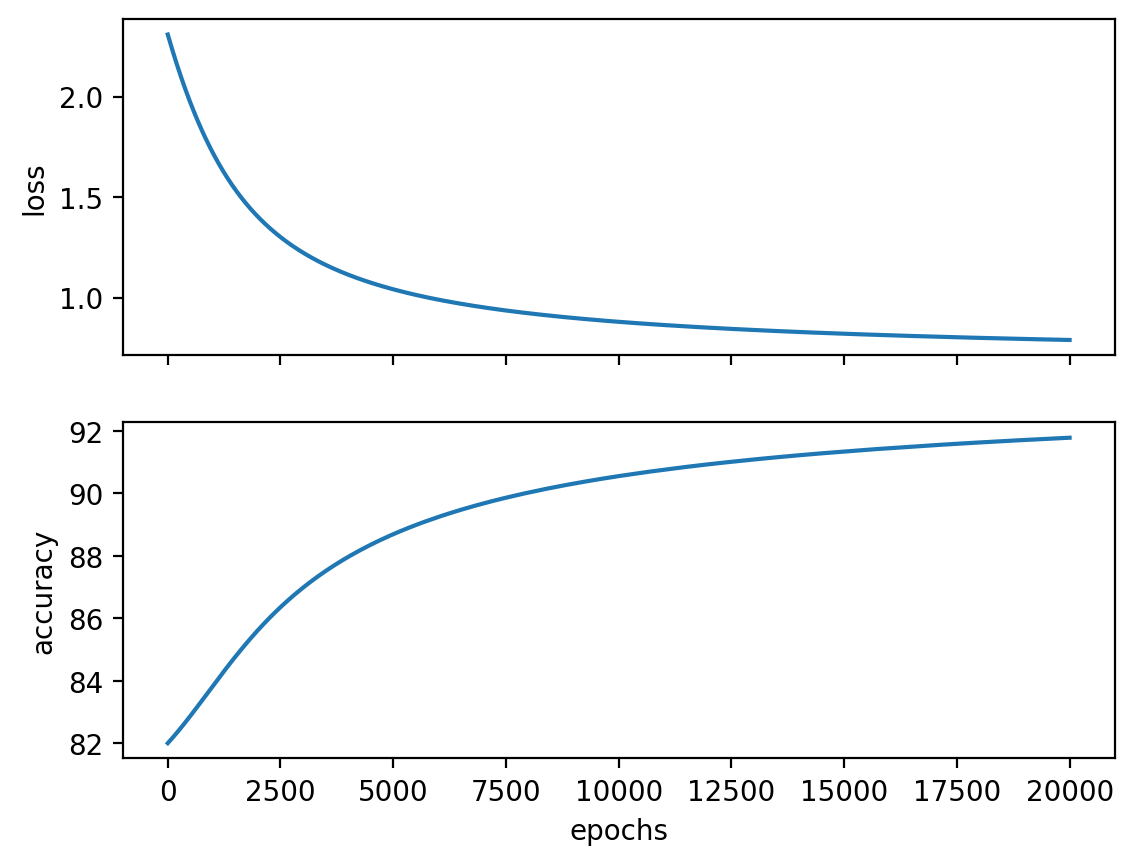

In [209]:
fig, [axA, axB] = plt.subplots(2, 1, sharex=True)

axA.plot(a)
axA.set_ylabel('loss')
axB.plot(b)
axB.set_ylabel('accuracy')

plt.xlabel('epochs')

plt.show()

In [ ]:
rbatch = np.random.choice(60000, size=BATCH)
# variables initialization
X = torch.autograd.Variable(x_train[rbatch])
Y = torch.autograd.Variable(y_train[rbatch])

A(Z(X))[1]

In [ ]:
Y

In [ ]:
# Create model
# f = wx + b, sigmoid at the end
class LogisticRegression(nn.Module):
    
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 10)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
    
model = LogisticRegression(2)

In [ ]:
# Loss and optimizer
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# training loop
num_epochs = 100
x_latent_data=x_latent_data.to(device)
y_train=y_train.to(device)
for epoch in range(num_epochs):
    # forward pass and loss

    
    y_predicted = model(x_latent_data).to(device)
    loss = criterion(y_predicted, y_train)
    
    # backward pass
    loss.backward()
    
    # updates
    optimizer.step()
    
    # zero gradients
    optimizer.zero_grad()
    
    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

In [ ]:
#y_train

In [ ]:
#encoded_data

In [ ]:
#y_vals
#z = torch.Tensor(z_vals).to(device)

In [ ]:
class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [ ]:
n_inputs = 10
n_outputs = 10
log_regr = LogisticRegression(n_inputs, n_outputs)

In [ ]:
# defining the optimizer
optimizer = torch.optim.SGD(log_regr.parameters(), lr=0.001)
# defining Cross-Entropy loss
criterion = torch.nn.CrossEntropyLoss()
 
epochs = 50
Loss = []
acc = []
for epoch in range(epochs):
    for i, (z_vals, y_vals) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = log_regr(images.view(-1, 28*28))
        loss = criterion(outputs, labels)
        # Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())
    correct = 0
    for images, labels in test_loader:
        outputs = log_regr(images.view(-1, 28*28))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(test_dataset)
    acc.append(accuracy)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

In [ ]:
len(z_vals[0]) # 469 * 128 = 60,000

In [ ]:
#z_vals

In [ ]:
#import pyro.distributions as dist

class LogisticRegression(nn.Module):

    def __init__(self, number_hidden_units, num_classes, encoder):
        super(LogisticRegression, self).__init__()

        self.encoder = encoder
        self.linear = nn.Linear(number_hidden_units, num_classes, )

    def forward(self, x):

        z_loc, z_scale = self.encoder.forward(x)
        z = dist.Normal(z_loc, z_scale).sample()

        out = self.linear(z)

        return out

In [ ]:
classifier = LogisticRegression(number_hidden_units=10, num_classes=10, encoder=vae.encoder)